In [1]:
import numpy as np
import math

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend as k
from sklearn.preprocessing import MinMaxScaler
# importing spencers code
import GeoSim2D_Multipath as geoSim

In [2]:
#gpu code
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [20]:
#Define the function that builds the model
def build_model(my_lr,signals, fshift,idx,fs1):
    model = Sequential()
    
    #Hidden layer. The input shape is 3 by 1024, 3 corresponds to the number of antenna elements.
    #1024 is the number of points in our FFT. input_shape needs to be changed if either of these two values(FFT_size,#of elements)
    #Are changed
    model.add(Dense(units = 5000,input_shape=(2,3,1024),activation = 'relu'))
    #Using relu because...
    model.add(Dense(units = 5000, activation = 'relu'))
    model.add(Dense(units = 6000, activation = 'relu'))
    model.add(Dense(units = 5000, activation = 'relu'))
    model.add(Dense(units = 50, activation = 'relu'))
    #flattening because...
    model.add(keras.layers.Flatten())
    model.add(Dense(units = 6, activation = 'sigmoid'))
    

    #Compile model topography
    #custom_loss my my own function and I have to send it necessary agruments that I first send to function build_model
    model.compile(optimizer=Adam(learning_rate =my_lr), loss=custom_loss(signals,fshift,idx,fs1),metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [23]:
def custom_loss(S,fshift,idx,fs1):
    def loss(y_true,y_pred):
        #explain
        #this is for 3 antenna elements: E0, E1, E2
        #y_pred[0,0] is the weight of antenna element 0
        #y_pred[0,1] is the weight of antenna element 1
        #y_pred[0,2] is the weight of antenna element 2
        #y_pred[0,3] is the time delay of antenna element 0
        #y_pred[0,4] is the time delay of antenna element 1
        #y_pred[0,5] is the time delay of antenna element 2
        

        signals = tf.constant(S)
        pi = math.pi
        y_pred = tf.cast(y_pred, tf.float64)
    
        
        k=y_true[0,0]
        E0_r = y_pred[0,0]*(signals[k][0][0]*tf.math.cos(-2*pi*fs1*y_pred[0,3]) - signals[k][1][0]*tf.math.sin(-2*pi*fs1*y_pred[0,3]))
        E0_im = y_pred[0,0]*(signals[k][0][0]*tf.math.sin(-2*pi*fs1*y_pred[0,3]) + signals[k][1][0]*tf.math.cos(-2*pi*fs1*y_pred[0,3]))
        
        E1_r = y_pred[0,1]*(signals[k][0][1]*tf.math.cos(-2*pi*fs1*y_pred[0,4]) - signals[k][1][1]*tf.math.sin(-2*pi*fs1*y_pred[0,4]))
        E1_im =y_pred[0,1]*(signals[k][0][1]*tf.math.sin(-2*pi*fs1*y_pred[0,4]) + signals[k][1][1]*tf.math.cos(-2*np.pi*fs1*y_pred[0,4]))
        
        E2_r =  y_pred[0,2]*(signals[k][0][2]*tf.math.cos(-2*pi*fs1*y_pred[0,5]) - signals[k][1][2]*tf.math.sin(-2*pi*fs1*y_pred[0,5]))
        E2_im = y_pred[0,2]*(signals[k][0][2]*tf.math.sin(-2*pi*fs1*y_pred[0,5]) + signals[k][1][2]*tf.math.cos(-2*pi*fs1*y_pred[0,5]))
        
        
        tf.print(k)
        
        #fs1 has to do with the transmitting frequency of the signal we are trying to receive
        #fs1 is a frequency array around the transmitting frequency
        #E0 = y_pred[0,0]*signals[0,0]*keras.backend.exp(-1j*2*np.pi*fs1*y_pred[0,3])
        #E1 = y_pred[0,1]*signals[0,1]*keras.backend.exp(-1j*2*np.pi*fs1*y_pred[0,4])
        #E2 = y_pred[0,2]*signals[0,2]*keras.backend.exp(-1j*2*np.pi*fs1*y_pred[0,5])
        sqr_E0 = tf.math.square(E0_r) + tf.math.square(E0_im)
        sqr_E1 = tf.math.square(E1_r) + tf.math.square(E1_im)
        sqr_E2 = tf.math.square(E2_r) + tf.math.square(E2_im)
        
        E0 = tf.math.sqrt(sqr_E0)                    
        E1 = tf.math.sqrt(sqr_E1)
        E2 = tf.math.sqrt(sqr_E2)
        
        #E_all the the signals summed from each antenna element
        E_all_num = 10*tf.math.log(E0+E1+E2)
        Denom = tf.math.log(tf.constant(10, dtype=E_all_num.dtype))
        E_all = E_all_num/Denom
        
        
        
        #Because keras backend do not have a polyfit function
        # I chose to just average the restricted domain collections
        #of fft values. Then created a straight line of this average height. 
        #this will serve as our flatness comparison
        
        #idx is an array of subscripts that correspond to our restricted domain
        #I need the number of values we want for the tf.slice function
        size = np.size(idx)
        #This reduces are signal array to just the domain we are checking for flatness
        E_all2 = tf.slice(E_all,[idx[0]],[size])
        
        #average the elements of mm
        B = keras.backend.sum(E_all2)/size
        #The average (scalar) is going to be multiplied to an array of ones to give us the flat/straight line comparison
        A = keras.backend.ones_like(E_all2)
        line = B*A
        
        #This part has been removed because I need polyfit
        ####reg = np.polyfit(fshift[idx],tf.slice(mm,[idx[0]],[np.size(idx)]),1)
        ####line = reg[0]*fshift[idx] +reg[1]
        
        #this sums the squared differences between the signal(E_all) and the flat line metric(line)
        sumSQ_error = keras.backend.sum((E_all2-line)**2)
        return sumSQ_error
    return loss


In [5]:
def train_model(model, signals, label, epoch, batch_size):
    #train the model by using the fit function
    #since we have our own metric for learning, 'label' is just a dummy variable of zeros
    #feature is array of signals (n,3,1024)
    
    history = []
    
    epochs = []
    
    hist = []
    
    trained_weight = []
    
    trained_bias = []
    
    loss = []
    t=0
    #for loop for the number of epochs I want
    for i in range(epoch):
        #print(i)
    
    #for loop the length of the first axis of signals to send in signals one at a time
    #I'll try to send the signals to the custom loss function through the y_label
        for j in range(np.size(signals,0)):
            this_Input = signals[None,j]
            
            idx = np.array([j,0,0,0,0,0])
            idx = np.reshape(idx, (1,6))
            
            #print(np.shape(this_Input))
            history= model.fit(x=this_Input,y=idx, batch_size=1, epochs=1)
        
            #epochs.append(history.epoch)
            t=t+1
            epochs.append(t)
            
            hist = pd.DataFrame(history.history)
                       
            trained_weight.append(model.get_weights()[0])
                       
            trained_bias.append(model.get_weights()[1])
                       
            loss.append(hist["loss"])
        
            #graph the loss like I do in the step search while it runs
    
    
    
    # This is the loss calculated at each epoch and can be used
    # to graph the loss
    #loss = hist["loss"]
    
    return trained_weight, trained_bias, epochs, loss

In [6]:
def plot_the_loss_curve(epochs, loss):
  #Plot the loss curve, which shows loss vs. epoch.
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
  
  
  #This is pretty straight forward, I take the two argument and graphs
  
    plt.plot(epochs, loss, label="Loss")
    plt.title('Loss Curve')
    plt.legend()
    plt.ylim([loss.min()*0.97, loss.max()])
    plt.xscale("log")
    plt.show()

In [7]:
#Gathering the addition input arguments that the model needs for the custom loss function

fs = 20e6 # sampling frequency

#This code is pulled from the multipath generation part and does not change. It actually doesn't need to be here 
#because everything is defined properly above. It is just helpful to see it here so we know what exactly is being
#passed into the model.
N=1024
fstemp = 2.44e9
# Create frequency array around fs1
fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)


#domain restriction (That .45 can be changed at will)
rang = int(N*.45)
start = int((N-rang)/2)
finish = start+rang
#idx is the collection of array elements corresponding to the restricted domain
idx = np.array(range(start,finish,1))

#fshift moves the FFT around zero... i believe

fshift = np.linspace(-fs/2,fs/2,num=N)


In [12]:
# Preping the signal data: It is important to get the signals as the right shape of a 3D array (n,3,1024)
# it is also important to scale the data

#CALL SPENCER'S FUNCTION
#
# creating blank arrays to store the values from the geometry simulator
signals            = [] # empty matrix to store each elements data
fshift = []
# inputs to geo sim
MP = 1
sample_size = 1024

# Generating the training data
num_sets = 20 # number of train signals to see results of the NN
mean = 100
for i in range(num_sets):
    avRec,fshift = geoSim.f_ave(mean,sample_size,MP)
    signals.append(avRec)             # storing the data for element 1
    fshift = fshift


(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)
(2, 3, 1024)


In [15]:
#Scale and shape the data

#final shaping
#signals = np.reshape(elements, (num_samples,3,1024))

#scaler = MinMaxScaler(feature_range=(0,1)) # testing -1,1 was 0,1
#scaled_signals = scaler.fit_transform(signals)

#text = signals[:][0]+1j*signals[:][1]
signals = np.asarray(signals)
print(np.shape(signals))
#signals.dtype

(20, 2, 3, 1024)


In [24]:
#dummy is the y value 'labels', the values don't matter, but the keras api want the right shape
dummy=np.zeros((num_sets,6))

#Pretty straight forwar, these can and should be toggled
learning_rate=0.0000000001
epoch=2
my_batch_size=1

#build the model, be sure to send the correct values in as arguments
my_model = build_model(learning_rate,signals,fshift,idx,fs1)

0
1/1 [==============================] - 3s 3s/step - loss: 4087.8901 - root_mean_squared_error: 0.6278
1
1/1 [==============================] - 0s 49ms/step - loss: 3573.9636 - root_mean_squared_error: 0.7815
2
1/1 [==============================] - 0s 51ms/step - loss: 462.9614 - root_mean_squared_error: 1.0851
3
1/1 [==============================] - 0s 49ms/step - loss: 2195.4785 - root_mean_squared_error: 1.3718
4
1/1 [==============================] - 0s 48ms/step - loss: 1824.5649 - root_mean_squared_error: 1.7991
5
1/1 [==============================] - 0s 48ms/step - loss: 2379.7056 - root_mean_squared_error: 2.1783
6
1/1 [==============================] - 0s 48ms/step - loss: 859.1853 - root_mean_squared_error: 2.5388
7
1/1 [==============================] - 0s 48ms/step - loss: 2479.9517 - root_mean_squared_error: 2.9078
8
1/1 [==============================] - 0s 48ms/step - loss: 3251.1018 - root_mean_squared_error: 3.3400
9
1/1 [==============================] - 0s 49ms/s

AttributeError: 'list' object has no attribute 'min'

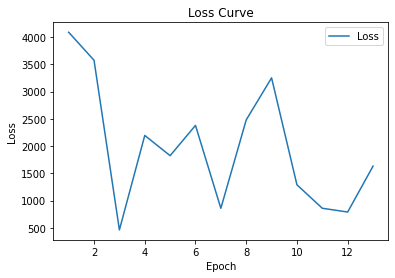

In [25]:
#Train the model and plot the loss

#this trains
trained_weight, trained_bias, epochs, loss = train_model(my_model, signals, dummy, epoch, my_batch_size)

#this plots
plot_the_loss_curve(epochs, loss)

In [ ]:
for i in range(10):
    m = np.array([i,0,0,0,0,0])
    print(m[0])